In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##PC:
# path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Pennings/Validation_2024' 
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Pennings/Validation_2024/2024.csv')

4036.388


C:\Users\arj26323\AppData\Local\Temp\ipykernel_15612\3627220723.py:9: FutureWarning: The provided callable <function sum at 0x000002BAFB427D00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year', 'Site'], as_index = False).aggregate(
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15612\3627220723.py:9: FutureWarning: The provided callable <function mean at 0x000002BAFB468CA0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year', 'Site'], as_index = False).aggregate(


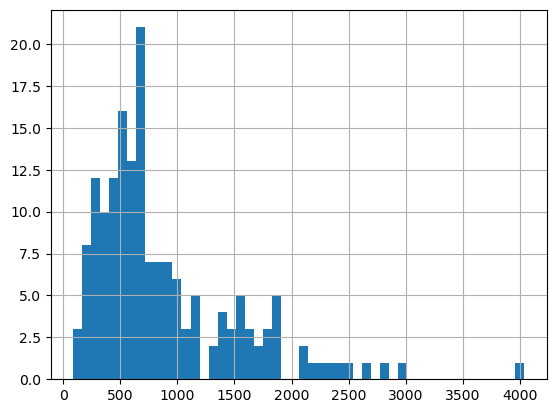

In [3]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

#df = df[df['Species_Code'] == 'A1'] ##Remove all non-Spartina alterniflora plots - messes up unique coordinates section
##Need to filter out other species later!

df = df[df['Zone'] >= 0] ##Zone "-1" in 2013 needs to be addressed - refers to old plot location that was relocated


df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year', 'Site'], as_index = False).aggregate(
    {
        'Plant_Biomass':[np.sum, np.size], 'Quadrat_Area':[np.mean], 
        'Species_Code':'first', 'Flowering_Status':'first','Date':'first'
    }
) 


df_sum.columns = [
    'Plot','Latitude','Longitude','Year','Site','Plant_Biomass', 'Sample_Size', 'Quadrat_Area', 'Species_Code',
    'Flowering_Status', 'Date'
]


df_sum['Plant_Biomass'] = df_sum['Plant_Biomass']/df_sum['Quadrat_Area']

df_sum['Plant_Biomass'].hist(bins = 50)

df_sum
print(max(df_sum['Plant_Biomass']))


In [4]:
##Exporting coordinates

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, '2024_validation.csv')

#df_sum.to_csv(out_csv)

In [5]:
df_sum
df0 = df_sum[['Latitude', 'Longitude', 'Year','Site', 'Plant_Biomass', 'Species_Code', 'Date']]
df0

,Latitude,Longitude,Year,Site,Plant_Biomass,Species_Code,Date
0,31.335090,-81.478689,2024,7.0,770.690,A4,2024-10-14
1,31.335155,-81.478596,2024,7.0,815.772,A4,2024-10-14
2,31.351197,-81.333752,2024,9.0,1625.696,A1,2024-10-17
3,31.388340,-81.280132,2024,6.0,378.160,A1,2024-10-11
4,31.436011,-81.340698,2024,5.0,585.600,A1,2024-10-15
...,...,...,...,...,...,...,...
163,31.388004,-81.279872,2024,6.0,929.688,A1,2024-10-11
164,31.387745,-81.279730,2024,6.0,303.892,A1,2024-10-11
165,31.307682,-81.415608,2024,8.0,1571.188,A13,2024-10-14
166,31.538427,-81.422332,2024,1.0,198.556,A1,2024-10-12


In [6]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [7]:
fc_all = geemap.pandas_to_ee(df0, latitude = "Latitude", longitude = "Longitude")

In [8]:
Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)
# Map.addLayer(fc_all, {}, 'points')
# Map

In [9]:
def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [10]:
def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.2)
    return image.updateMask(mask1)

##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [11]:
##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
# def rasterExtraction(image):
#     feature = image.sampleRegions(
#         collection = fc_all,
#         scale = 30,
#         tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
#     )
#     return feature


def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

##FOR 1m DEM:
def dem1Extraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 1, 
        tileScale = 16 #ADDED 11/7/2022

    )
    return feature

In [12]:
ls8_collect = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)
ls9_collect = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)

#Merge
ultra_col = ls8_collect.merge(ls9_collect)

In [13]:
##Adding DEM
dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.
dem1 = ee.ImageCollection('USGS/3DEP/1m')

##Set visualization parameters.
dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map.addLayer(dem, dem_params, '10m DEM')

In [14]:
#LANDSAT extraction

def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# Split locations into batches of 100
batch_size = 70
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = ultra_col.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"GALandsat_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")

# #2013 onward - need to reduce batch size from 200

In [15]:
##DAYMET
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_all).filterDate('2023', '2025')

# def dmExtraction(image, fc_subset):
#     return image.sampleRegions(
#         collection=fc_subset,
#         scale=1000,
#         tileScale=8  # Reducing from 16 to 8 to improve efficiency
#     ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

#Resampling daymet collection to 30m
def resamp_dm(img):
    resampled_dm = img.reproject(
        crs = 'EPSG:4326',
        scale = 30
    ).resample('bilinear')
    return resampled_dm
resamp_daymet = daymet.map(resamp_dm).map(addDate) #not sure if anything is actually changed

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')



def xxx(image):
    return image.sampleRegions(
        collection=fc_all,
        scale=1000,
        tileScale=8  # Reducing from 16 to 8 to improve efficiency
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


extracted_features = resamp_daymet.map(xxx)
fc_dict = extracted_features.getInfo()   
features = [feature['properties'] for feature in fc_dict['features']]
df = pd.DataFrame(features)
df


# Split locations into batches of 100
batch_size = 70
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = resamp_daymet.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"GADaymet_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")

In [16]:
##GRIDMET
gridmet = ee.ImageCollection('GRIDMET/DROUGHT').filterBounds(fc_all)

resamp_gridmet = gridmet.map(resamp_dm).map(addDate)

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# Split locations into batches of 100
batch_size = 100
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = resamp_gridmet.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"GAGridmet_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")

In [17]:
#Elevation

##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.

#Elevation
dem_extract = demExtraction(dem)
# dem_vals = geemap.ee_to_csv(dem_extract, 'dem.csv') ##10m dataset

dem_dict = dem_extract.getInfo()

# Extract the properties of the features into a list of dictionaries
features = [feature['properties'] for feature in dem_dict['features']]

# Convert the list of dictionaries into a pandas DataFrame
dem_vals = pd.DataFrame(features)
dem_vals

# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "elev.csv")

# dem_vals.to_csv(filename, index=False)

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,elevation
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,4.067061e-01
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,1.078084e+00
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,9.487317e-01
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,8.678362e-01
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,1.198446e+00
...,...,...,...,...,...,...,...,...
163,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,8.062134e-01
164,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,1.040456e+00
165,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,9.059039e-01
166,"{'type': 'Date', 'value': 1728691200000}",31.538427,-81.422332,198.556,1,A1,2024,1.175494e-38


In [18]:
##Slope
slope = ee.Terrain.slope(dem);

#Elevation
slope_extract = demExtraction(slope)

slope_dict = slope_extract.getInfo()

# Extract the properties of the features into a list of dictionaries
features = [feature['properties'] for feature in slope_dict['features']]

# Convert the list of dictionaries into a pandas DataFrame
slope_vals = pd.DataFrame(features)
slope_vals

# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "slope.csv")

# slope_vals.to_csv(filename, index=False)

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,slope
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,2.183989
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,3.193870
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,1.188487
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,0.211766
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,0.498352
...,...,...,...,...,...,...,...,...
163,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,1.031260
164,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,3.422582
165,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,3.436091
166,"{'type': 'Date', 'value': 1728691200000}",31.538427,-81.422332,198.556,1,A1,2024,1.069874


In [19]:
years_dm = range(2024, 2025)


In [22]:
#Daymet
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 30,
        tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
    )
    return feature


##COLLECTION
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_all)

#Resampling daymet collection to 30m
def resamp_dm(img):
    resampled_dm = img.reproject(
        crs = 'EPSG:4326',
        scale = 30
    ).resample('bilinear')
    return resampled_dm
resamp_daymet = daymet.map(resamp_dm)

def MayOct_Max (collection, years):
  maxim = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter and set month
      Monthly_maxim = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(5, 10, 'month')) \
                              .max() \
                              .set({'year': year})
      maxim.append (Monthly_maxim)
  return ee.ImageCollection.fromImages(maxim)

def peakdm_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(8, 10, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)


#Peak biomass
peak_dm = peakdm_Avg(resamp_daymet, years = years_dm) #Updated to resampled daymet collection!
peakdm_list = peak_dm.toList(peak_dm.size())

#Max
Max_dm = MayOct_Max(resamp_daymet, years = years_dm) #Updated to resampled daymet collection!
dm_Max_list = Max_dm.toList(Max_dm.size())

In [29]:
#Gridmet functions, pay attention to date - SPEI14D is AVERAGE OVER YEAR
gridmet = ee.ImageCollection('GRIDMET/DROUGHT').filterBounds(fc_all)

def add_year(image):
    year = ee.Date(image.get("system:time_start")).get("year")
    return image.set("Year", year)

gridmet_resamp = gridmet.map(resamp_dm).map(add_year)

def gm_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(1, 12, 'month')) \
                              .mean() \
                              .set({'year': year, 'system:time_start': ee.Date.fromYMD(year, 1, 1).millis()})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)


#Over year
monthly_gridmet = gm_Avg(gridmet_resamp, years = years_dm) #Updated to resampled daymet collection!
gridmet_list = monthly_gridmet.toList(monthly_gridmet.size())


##INCLUDING PEAK_DM to check with final results!!!

def peakgm_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(8, 10, 'month')) \
                              .mean() \
                              .set({'year': year, 'system:time_start': ee.Date.fromYMD(year, 8, 1).millis()})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

#Peak biomass
peak_gridmet = peakgm_Avg(gridmet_resamp, years = years_dm) #Updated to resampled daymet collection!
peakgridmet_list = peak_gridmet.toList(peak_gridmet.size())

In [ ]:
##Extractions

In [24]:
#Daymet peak time

daymet_list = []
for i in range(len(years_dm)):
    dm_x = rasterExtraction(ee.Image(peakdm_list.get(i)))
    fc_dict = dm_x.getInfo()
    features = [feature['properties'] for feature in fc_dict['features']]
    ydf = pd.DataFrame(features)
    sampledm = ydf[ydf['Year'] == years_dm[i]]
    daymet_list.append(sampledm) 
    
# daymet_list = []
# for i in range(len(years_dm)):
#     dm_x = geemap.ee_to_pandas(rasterExtraction(ee.Image(peakdm_list.get(i))))
#     sampledm = dm_x[dm_x['Year'] == years_dm[i]]
#     daymet_list.append(sampledm) 
    
peakdaymet_extract = pd.concat(daymet_list)

peakdaymet_extract

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,dayl,prcp,srad,swe,tmax,tmin,vp
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,43638.546875,6.729239,329.383698,0,29.551956,20.157825,2423.821777
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,43638.546875,6.729239,329.383698,0,29.551956,20.157825,2423.821777
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,43639.546875,6.988587,323.802704,0,29.521631,20.792282,2511.089844
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,43639.546875,7.018261,319.494446,0,29.492718,20.996956,2539.837158
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,43640.546875,6.502717,326.161530,0,29.533695,20.554131,2478.185059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,"{'type': 'Date', 'value': 1729123200000}",31.351949,-81.333980,1663.272,9,A1,2024,43639.546875,6.988587,323.802704,0,29.521631,20.792282,2511.089844
148,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,43639.546875,7.018261,319.494446,0,29.492718,20.996956,2539.837158
149,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,43639.546875,7.018261,319.494446,0,29.492718,20.996956,2539.837158
150,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,43638.546875,7.028804,326.207397,0,29.523804,20.514130,2472.349365


In [25]:
#Max daymet extraction

daymet_list = []
for i in range(len(years_dm)):
    dm_x = rasterExtraction(ee.Image(dm_Max_list.get(i)))
    fc_dict = dm_x.getInfo()
    features = [feature['properties'] for feature in fc_dict['features']]
    ydf = pd.DataFrame(features)
    sampledm = ydf[ydf['Year'] == years_dm[i]]
    daymet_list.append(sampledm) 
    
dm_Max_extract = pd.concat(daymet_list)

dm_Max_extract

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,dayl,prcp,srad,swe,tmax,tmin,vp
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,50542.179688,121.639999,500.140015,0,36.200001,25.620001,3286.260010
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,50542.179688,121.639999,500.140015,0,36.200001,25.620001,3286.260010
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,50559.128906,113.940002,505.140015,0,36.209999,25.950001,3350.000000
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,50559.128906,110.620003,506.859985,0,36.180000,26.080000,3377.129883
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,50576.109375,116.279999,501.410004,0,36.119999,25.889999,3339.179932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,"{'type': 'Date', 'value': 1729123200000}",31.351949,-81.333980,1663.272,9,A1,2024,50559.128906,113.940002,505.140015,0,36.209999,25.950001,3350.000000
148,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,50559.128906,110.620003,506.859985,0,36.180000,26.080000,3377.129883
149,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,50559.128906,110.620003,506.859985,0,36.180000,26.080000,3377.129883
150,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,50542.179688,116.959999,502.630005,0,36.220001,25.760000,3313.060059


In [26]:
#Gridmet season

def add_year(image):
    return image.set("Year", ee.Date(image.date()).get("year"))

daymet_list = []
for i in range(len(years_dm)):
    dm_x = rasterExtraction(add_year(ee.Image(gridmet_list.get(i))))
    fc_dict = dm_x.getInfo()
    features = [feature['properties'] for feature in fc_dict['features']]
    ydf = pd.DataFrame(features)
    sampledm = ydf[ydf['Year'] == years_dm[i]]
    daymet_list.append(sampledm) 
    
gridmet_extract = pd.concat(daymet_list)

In [30]:
#Gridmet peak time

daymet_list = []
for i in range(len(years_dm)):
    dm_x = rasterExtraction(add_year(ee.Image(peakgridmet_list.get(i))))
    fc_dict = dm_x.getInfo()
    features = [feature['properties'] for feature in fc_dict['features']]
    ydf = pd.DataFrame(features)
    sampledm = ydf[ydf['Year'] == years_dm[i]]
    daymet_list.append(sampledm) 
    
peakgridmet_extract = pd.concat(daymet_list)

In [34]:
gridmet_extract

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,eddi14d,eddi180d,eddi1y,...,spei90d,spi14d,spi180d,spi1y,spi270d,spi2y,spi30d,spi5y,spi90d,z
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,0.215205,0.340822,0.472055,...,1.018767,0.278493,1.710137,2.073562,1.910822,2.090000,0.483151,2.090000,1.165342,2.416164
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,0.215205,0.340822,0.472055,...,1.018767,0.278493,1.710137,2.073562,1.910822,2.090000,0.483151,2.090000,1.165342,2.416164
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,0.289726,0.442466,0.417671,...,0.636438,0.106027,0.981644,1.448630,1.212329,1.802603,0.295616,1.834658,0.781370,1.247808
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,0.329315,0.467945,0.403973,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,0.320548,0.426849,0.430685,...,0.686027,0.111918,0.979726,1.064932,1.011644,1.186575,0.292055,0.478082,0.847397,1.360822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,0.329315,0.467945,0.403973,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
164,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,0.329315,0.467945,0.403973,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
165,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,0.266575,0.403425,0.507534,...,0.983151,0.269452,1.642603,2.073562,1.875342,2.090000,0.463425,2.090000,1.150685,2.324110
166,"{'type': 'Date', 'value': 1728691200000}",31.538427,-81.422332,198.556,1,A1,2024,0.278082,0.433151,0.417123,...,0.827945,0.225616,1.071781,1.036027,1.067945,1.040411,0.432192,1.435205,0.975342,1.428767


In [35]:
#Merging
peakdaymet_extract.rename(
    columns={
        'swe':'swe_peak','tmax':'tmax_peak','tmin':'tmin_peak','srad':'srad_peak', 'vp':'vp_peak',
        'prcp':'prcp_peak', 'dayl':'dayl_peak'
    }, inplace=True
)

dm_Max_extract.rename(
    columns={
        'swe':'swe_max','tmax':'tmax_max','tmin':'tmin_max','srad':'srad_max', 'vp':'vp_max',
        'prcp':'prcp_max', 'dayl':'dayl_max'
    }, inplace=True
)

dfx1 = pd.merge(peakdaymet_extract, dm_Max_extract, on = ['Plant_Biomass', 'Latitude', 'Longitude', 'Site', 'Year'], 
                how='right', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')



dfx_yeargrid = pd.merge(dfx1, gridmet_extract, on = ['Plant_Biomass', 'Latitude', 'Longitude', 'Site', 'Year'], how='right',
                 suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')


dfx_peak_grid = pd.merge(dfx1, peakgridmet_extract, on = ['Plant_Biomass', 'Latitude', 'Longitude','Site', 'Year'], how='right',
                 suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [42]:
dfx_peak_grid
dfx_yeargrid

# for col in dfx_yeargrid.columns:
#     print(col)



# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "dm_gmpeak.csv")

# dfx_peak_grid.to_csv(filename, index=False)

In [54]:
##MERGING ALL FINAL DATASETS INTO TWO DFS: one with peak avg dm and one with year avg dm

#First, appending landsat batches
path = r'C:/Users/arj26323/Documents/All extract/2024_Validation/landsat_batches' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    lsdf = pd.read_csv(filename, index_col=None, header=0)
    li.append(lsdf)

lsdf = pd.concat(li, axis=0, ignore_index=True)

x1 = pd.read_csv('C:/Users/arj26323/Documents/All extract/2024_Validation/elev.csv')
x2 = pd.read_csv('C:/Users/arj26323/Documents/All extract/2024_Validation/slope.csv')
x3 = pd.read_csv('C:/Users/arj26323/Documents/All extract/2024_Validation/percent_flooding.csv')
x4_yr = pd.read_csv('C:/Users/arj26323/Documents/All extract/2024_Validation/dm_gmyear.csv')
x4_peak = pd.read_csv('C:/Users/arj26323/Documents/All extract/2024_Validation/dm_gmpeak.csv')

,index,Latitude,Longitude,Percent_flooding
0,0,31.308449,-81.415129,0.014085
1,14,31.308449,-81.415129,0.014085
2,23,31.308539,-81.415218,0.014085
3,39,31.308539,-81.415218,0.014085
4,46,31.308659,-81.415257,0.011858
...,...,...,...,...
388,3486,31.539480,-81.422098,0.011461
389,3489,31.539491,-81.421750,0.011594
390,3505,31.539491,-81.421750,0.011594
391,3511,31.539505,-81.421937,0.011594


In [68]:
df1

,Date,Latitude,Longitude,Plant_Biomass,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,...,ST_TRAD,ST_URAD,Site,Species_Code,Year,date,flats,Sensor,LS_datetime,LS_year
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,21824,0,0.019422,0.028993,0.044365,0.051900,...,7461,1016,7,A4,2024,"{'type': 'Date', 'value': 1728864000000}",0.004991,Landsat 8/9,NaT,NaN
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,21824,0,0.022227,0.029350,0.041313,0.045135,...,7473,1016,7,A4,2024,"{'type': 'Date', 'value': 1728864000000}",0.009810,Landsat 8/9,NaT,NaN
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,21824,0,0.040625,0.039635,0.045025,0.045327,...,7546,1024,9,A1,2024,"{'type': 'Date', 'value': 1729123200000}",0.001306,Landsat 8/9,NaT,NaN
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,21824,0,0.040570,0.041368,0.046207,0.045987,...,7540,1023,6,A1,2024,"{'type': 'Date', 'value': 1728604800000}",0.013636,Landsat 8/9,NaT,NaN
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,21824,0,0.038920,0.041147,0.052202,0.051597,...,7470,1018,5,A1,2024,"{'type': 'Date', 'value': 1728950400000}",0.017700,Landsat 8/9,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7289,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,21952,0,0.034107,0.039387,0.053550,0.048490,...,7451,573,6,A1,2024,"{'type': 'Date', 'value': 1728604800000}",0.923020,Landsat 8/9,NaT,NaN
7290,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,21824,0,0.035373,0.039552,0.049837,0.045767,...,7454,573,6,A1,2024,"{'type': 'Date', 'value': 1728604800000}",0.576475,Landsat 8/9,NaT,NaN
7291,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,21952,0,0.027507,0.032183,0.047912,0.054457,...,7569,575,8,A13,2024,"{'type': 'Date', 'value': 1728864000000}",0.962633,Landsat 8/9,NaT,NaN
7292,"{'type': 'Date', 'value': 1728691200000}",31.538427,-81.422332,198.556,21824,0,0.015105,0.019533,0.030202,0.030120,...,7347,554,1,A1,2024,"{'type': 'Date', 'value': 1728691200000}",0.007769,Landsat 8/9,NaT,NaN


In [102]:
df1 = lsdf ##be careful of object reuse higher up

df1['Sensor'] = np.where(df1['ST_B10'].isna(),'Landsat 5/7', 'Landsat 8/9')

# DATE ISSUE FIXED HERE
df1['Date'].apply(type).value_counts()

df1['date'] = df1['Date'].str.extract(r"(\d{13})").astype(float)
df1['date'] = pd.to_datetime(df1['date'], unit='ms', errors='coerce')

#Datetime and year for LS data and biomass sampling data
df1['LS_datetime'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
df1['LS_year'] = df1['LS_datetime'].dt.strftime('%Y')

df1['Sampling_datetime'] = pd.to_datetime(df1['date'])
df1['Sampling_year'] = df1['Sampling_datetime'].dt.strftime('%Y')

df1['Month'] = df1['LS_datetime'].dt.month #IMPORTANT FOR VARIABLES! MUST BE SAMPLING LS TIME

#Renaming bands, based on Landsat sensors

df1['Blue_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B2'], df1['SR_B1'])
df1['Green_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B3'], df1['SR_B2'])
df1['Red_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B4'], df1['SR_B3'])
df1['NIR_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B5'], df1['SR_B4'])
df1['SWIR1_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B6'], df1['SR_B5'])
df1['SWIR2_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B7'], df1['SR_B7'])


##Indices (make sure calculations are accurate):
df1['savi'] = ((df1['NIR_band']-df1['Red_band'])*1.5)/(df1['NIR_band']+df1['Red_band']+0.5)
df1['wdrvi5'] = (0.5*df1['NIR_band']-df1['Red_band'])/(0.5*df1['NIR_band']+df1['Red_band'])
df1['nd_r_g'] = (df1['Red_band']-df1['Green_band'])/(df1['Red_band']+df1['Green_band'])
df1['nd_g_b'] = (df1['Green_band']-df1['Blue_band'])/(df1['Green_band']+df1['Blue_band'])
df1['nd_swir2_nir'] = (df1['SWIR2_band']-df1['NIR_band'])/(df1['SWIR2_band']+df1['NIR_band'])
df1['nd_swir2_r'] = (df1['SWIR2_band']-df1['Red_band'])/(df1['SWIR2_band']+df1['Red_band'])
df1['evi'] =((df1['NIR_band']-df1['Red_band'])*2.5)/(df1['NIR_band']+6*df1['Red_band']+7.5*df1['Blue_band']+1)
df1['ndvi'] = ((df1['NIR_band']-df1['Red_band']))/(df1['NIR_band']+df1['Red_band'])


df1['Date']

pairsite = df1[['Latitude', 'Longitude', 'Site', 'Plant_Biomass']].drop_duplicates()

In [103]:
##ADDITIONAL GROUP BY LS YEAR

def seasonal_band_stats(df, start_month, end_month, bands, stat_name='mean'):
    # Filter by month range
    df_season = df[(df['Month'] >= start_month) & (df['Month'] <= end_month)]
    
    # Filter to only those rows where LS_year matches Sampling_year
    df_season = df_season[df_season['LS_year'] == df_season['Sampling_year']]

    # Grouping by location and both year types
    group_cols = ['Latitude', 'Longitude', 'Sampling_year', 'LS_year']  ##ADD SITE???????
    
    # Choose aggregation function
    if stat_name == 'mean':
        agg_func = 'mean'
    elif stat_name == 'min':
        agg_func = 'min'
    elif stat_name == 'max':
        agg_func = 'max'
    elif stat_name == 'median':
        agg_func = 'median'
    elif stat_name == 'sum':
        agg_func = 'sum'    
    else:
        raise ValueError("stat_name must be 'mean', 'min', 'max', 'sum,' or 'median'")
    
    # Perform aggregation
    df_grouped = df_season.groupby(group_cols)[bands].agg(agg_func).reset_index()
    
    # Rename columns to reflect the operation and month window
    suffix = f'{stat_name}_{start_month:02d}_{end_month:02d}'
    df_grouped = df_grouped.rename(columns={col: f'{col}_{suffix}' for col in bands})
    
    return df_grouped

In [104]:
##Flooding dataset                                              )

df1_flooding = x3
##DO NOT GROUP FLOODING PERCENT BY LS_YEAR - you want the total percent flooding over the entire time period. ADD AT END?

df1_flooding

,index,Latitude,Longitude,Percent_flooding
0,0,31.308449,-81.415129,0.014085
1,14,31.308449,-81.415129,0.014085
2,23,31.308539,-81.415218,0.014085
3,39,31.308539,-81.415218,0.014085
4,46,31.308659,-81.415257,0.011858
...,...,...,...,...
388,3486,31.539480,-81.422098,0.011461
389,3489,31.539491,-81.421750,0.011594
390,3505,31.539491,-81.421750,0.011594
391,3511,31.539505,-81.421937,0.011594


In [105]:
##FLATS+ FILTERING!!
df1_filtered = df1[df1['flats'] < 0.2]

In [106]:
##Calculating variables of interest

bands_of_interest = ['ndvi', 'evi', 'nd_swir2_nir', 'nd_r_g']

##AUGOCT - PEAK
# Calculate average
mean_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='mean')
# Calculate max
max_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='max')


##MAYOCT - GROWING
# Calculate average
mean_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='mean')
# Calculate max
max_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='max')


In [107]:
df_final = mean_augoct
df_final = df_final.merge(max_augoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')


df_final = df_final.merge(mean_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(max_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')


#Add df1_flooding
df_final = df_final.merge(df1_flooding, on=['Latitude', 'Longitude'], how='left')

#Add elevation
elev_10 = x1
elev_10 = elev_10[['Latitude', 'Longitude', 'elevation']]

#Add slope
slope_10 = x2
slope_10 = slope_10[['Latitude', 'Longitude', 'slope']]



df_final = df_final.merge(elev_10, on=['Latitude', 'Longitude'], how='left')
df_final = df_final.merge(slope_10, on=['Latitude', 'Longitude'], how='left')

# df_final['DSM'] = df_final.groupby(['Latitude', 'Longitude'])['DSM'].transform('first') ##Populating empty DSM vals

#Adding site information back
df_final = df_final.merge(pairsite, on=['Latitude', 'Longitude'], how='left')

df_final #elev merge added 6 extra rows...

,Latitude,Longitude,Sampling_year,LS_year,ndvi_mean_08_10,evi_mean_08_10,nd_swir2_nir_mean_08_10,nd_r_g_mean_08_10,ndvi_max_08_10,evi_max_08_10,...,ndvi_max_05_10,evi_max_05_10,nd_swir2_nir_max_05_10,nd_r_g_max_05_10,index,Percent_flooding,elevation,slope,Site,Plant_Biomass
0,31.307529,-81.415324,2024,2024,0.403419,0.108280,-0.409078,0.029238,0.603944,0.184640,...,0.603944,0.184640,-0.265013,0.086618,NaN,NaN,4.492185e-01,4.810517,8,705.844
1,31.307562,-81.415389,2024,2024,0.403419,0.108280,-0.409078,0.029238,0.603944,0.184640,...,0.603944,0.184640,-0.265013,0.086618,NaN,NaN,1.104456e-38,3.174512,8,307.340
2,31.307641,-81.415468,2024,2024,0.403419,0.108280,-0.409078,0.029238,0.603944,0.184640,...,0.603944,0.184640,-0.265013,0.086618,NaN,NaN,1.073180e-01,4.399401,8,1368.024
3,31.307682,-81.415608,2024,2024,0.332366,0.061815,-0.464747,0.003890,0.403197,0.072387,...,0.403197,0.072387,-0.376261,0.027074,NaN,NaN,9.059039e-01,3.436091,8,1571.188
4,31.307760,-81.415721,2024,2024,0.332366,0.061815,-0.464747,0.003890,0.403197,0.072387,...,0.403197,0.072387,-0.376261,0.027074,NaN,NaN,6.261902e-01,4.108952,8,2113.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,31.539429,-81.422410,2024,2024,0.537616,0.168081,-0.319907,0.036274,0.649111,0.248895,...,0.649111,0.248895,-0.189088,0.069421,3427.0,0.020000,1.189945e+00,0.977760,1,969.296
164,31.539457,-81.422250,2024,2024,0.569528,0.191440,-0.343283,0.033398,0.675398,0.283564,...,0.675398,0.283564,-0.244164,0.060672,3448.0,0.011461,1.182926e+00,0.787721,1,591.296
165,31.539480,-81.422098,2024,2024,0.569528,0.191440,-0.343283,0.033398,0.675398,0.283564,...,0.675398,0.283564,-0.244164,0.060672,3467.0,0.011461,1.134844e+00,0.408953,1,794.112
166,31.539491,-81.421750,2024,2024,0.549759,0.180000,-0.317456,0.039926,0.670603,0.272846,...,0.670603,0.272846,-0.211278,0.088999,3489.0,0.011594,1.014134e+00,0.220574,1,531.984


In [108]:
x4_yr

,Date,Latitude,Longitude,Plant_Biomass,Site,Species_Code,Year,dayl_peak,prcp_peak,srad_peak,...,spei90d,spi14d,spi180d,spi1y,spi270d,spi2y,spi30d,spi5y,spi90d,z
0,"{'type': 'Date', 'value': 1728864000000}",31.335090,-81.478689,770.690,7,A4,2024,43638.546875,6.729239,329.383698,...,1.018767,0.278493,1.710137,2.073562,1.910822,2.090000,0.483151,2.090000,1.165342,2.416164
1,"{'type': 'Date', 'value': 1728864000000}",31.335155,-81.478596,815.772,7,A4,2024,43638.546875,6.729239,329.383698,...,1.018767,0.278493,1.710137,2.073562,1.910822,2.090000,0.483151,2.090000,1.165342,2.416164
2,"{'type': 'Date', 'value': 1729123200000}",31.351197,-81.333752,1625.696,9,A1,2024,43639.546875,6.988587,323.802704,...,0.636438,0.106027,0.981644,1.448630,1.212329,1.802603,0.295616,1.834658,0.781370,1.247808
3,"{'type': 'Date', 'value': 1728604800000}",31.388340,-81.280132,378.160,6,A1,2024,43639.546875,7.018261,319.494446,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
4,"{'type': 'Date', 'value': 1728950400000}",31.436011,-81.340698,585.600,5,A1,2024,43640.546875,6.502717,326.161530,...,0.686027,0.111918,0.979726,1.064932,1.011644,1.186575,0.292055,0.478082,0.847397,1.360822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,"{'type': 'Date', 'value': 1728604800000}",31.388004,-81.279872,929.688,6,A1,2024,43639.546875,7.018261,319.494446,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
164,"{'type': 'Date', 'value': 1728604800000}",31.387745,-81.279730,303.892,6,A1,2024,43639.546875,7.018261,319.494446,...,0.552192,0.075479,0.885890,1.077397,1.052466,1.313151,0.265616,1.475206,0.697671,1.269041
165,"{'type': 'Date', 'value': 1728864000000}",31.307682,-81.415608,1571.188,8,A13,2024,43638.546875,7.028804,326.207397,...,0.983151,0.269452,1.642603,2.073562,1.875342,2.090000,0.463425,2.090000,1.150685,2.324110
166,"{'type': 'Date', 'value': 1728691200000}",31.538427,-81.422332,198.556,1,A1,2024,43642.554688,5.900109,331.936859,...,0.827945,0.225616,1.071781,1.036027,1.067945,1.040411,0.432192,1.435205,0.975342,1.428767


In [113]:
##Adding daymet and year average gridmet
df_met_year = df_final.copy().merge(x4_yr, on = ['Latitude', 'Longitude', 'Plant_Biomass'], how='left') 
df_met_year['Yr'] = pd.to_datetime(df_met_year['Sampling_year'])

val_year = df_met_year.dropna()

##Adding daymet and peak average gridmet
df_met_peak = df_final.copy().merge(x4_peak, on = ['Latitude', 'Longitude', 'Plant_Biomass'], how='left') 
df_met_peak['Yr'] = pd.to_datetime(df_met_peak['Sampling_year'])

val_peak = df_met_peak.dropna()

val_peak

,Latitude,Longitude,Sampling_year,LS_year,ndvi_mean_08_10,evi_mean_08_10,nd_swir2_nir_mean_08_10,nd_r_g_mean_08_10,ndvi_max_08_10,evi_max_08_10,...,spi14d,spi180d,spi1y,spi270d,spi2y,spi30d,spi5y,spi90d,z,Yr
8,31.308449,-81.415129,2024,2024,0.516085,0.168008,-0.288367,0.047430,0.616881,0.268523,...,0.198421,2.090000,2.090000,2.090000,2.090000,0.649474,2.090000,1.822105,3.264210,2024-01-01
9,31.308539,-81.415218,2024,2024,0.516085,0.168008,-0.288367,0.047430,0.616881,0.268523,...,0.198421,2.090000,2.090000,2.090000,2.090000,0.649474,2.090000,1.822105,3.264210,2024-01-01
10,31.308659,-81.415257,2024,2024,0.518223,0.176373,-0.302883,0.045520,0.621741,0.272542,...,0.198421,2.090000,2.090000,2.090000,2.090000,0.649474,2.090000,1.822105,3.264210,2024-01-01
11,31.308750,-81.415322,2024,2024,0.492325,0.153893,-0.258351,0.057588,0.589018,0.239095,...,0.198421,2.090000,2.090000,2.090000,2.090000,0.649474,2.090000,1.822105,3.264210,2024-01-01
12,31.308849,-81.415465,2024,2024,0.496774,0.160115,-0.275998,0.062650,0.600051,0.248790,...,0.198421,2.090000,2.090000,2.090000,2.090000,0.649474,2.090000,1.822105,3.264210,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,31.539429,-81.422410,2024,2024,0.537616,0.168081,-0.319907,0.036274,0.649111,0.248895,...,0.251053,1.698421,1.452105,1.774211,1.413684,0.837895,1.732105,1.781053,2.983684,2024-01-01
164,31.539457,-81.422250,2024,2024,0.569528,0.191440,-0.343283,0.033398,0.675398,0.283564,...,0.251053,1.698421,1.452105,1.774211,1.413684,0.837895,1.732105,1.781053,2.983684,2024-01-01
165,31.539480,-81.422098,2024,2024,0.569528,0.191440,-0.343283,0.033398,0.675398,0.283564,...,0.251053,1.698421,1.452105,1.774211,1.413684,0.837895,1.732105,1.781053,2.983684,2024-01-01
166,31.539491,-81.421750,2024,2024,0.549759,0.180000,-0.317456,0.039926,0.670603,0.272846,...,0.251053,1.698421,1.452105,1.774211,1.413684,0.837895,1.732105,1.781053,2.983684,2024-01-01


In [115]:
##FINAL EXPORT

# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "val_year.csv")

# val_year.to_csv(filename, index=False)